# BILSTM-CRF fasttext on dataset 1

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
import gensim.downloader as api
import json
import matplotlib.pyplot as plt

# Load pre-trained word embeddings (FastText)
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")

In [3]:
# Define the BiLSTM-CRF model
class BiLSTMCRFTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, word_embeddings):
        super(BiLSTMCRFTagger, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        self.crf = CRF(tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        return tag_space

# Define the dataset
class ReviewDataset(Dataset):
    def __init__(self, data_path, word_vectors, max_seq_length):
        self.data_path = data_path
        self.word_vectors = word_vectors
        self.max_seq_length = max_seq_length
        self.data = self.load_data()
        self.word_to_idx, self.label_to_idx = self.prepare_vocab()
        self.X, self.y = self.prepare_data()

    def load_data(self):
        with open(self.data_path, 'r') as f:
            data = json.load(f)
        if isinstance(data, list):
            data = {str(idx): sample for idx, sample in enumerate(data)}
        return data

    def prepare_vocab(self):
        word_to_idx = {word: idx + 1 for idx, word in enumerate(self.word_vectors.index_to_key)}
        label_to_idx = {"O": 1, "B_RESPONDENT": 2, "I_RESPONDENT": 3, "B_DATE": 4, "I_DATE":5, "B_GPE": 6, "I_GPE": 7, "B_PROVISION": 8, 
                        "I_PROVISION": 9, "B_STATUTE": 10, "I_STATUTE": 11, "B_ORG": 12, "B_CASE_NUMBER": 13, "I_CASE_NUMBER": 14, 
                        "B_OTHER_PERSON": 15, "I_OTHER_PERSON": 16, "B_WITNESS": 17, "I_WITNESS": 18, "I_ORG": 19, "B_JUDGE": 20, "I_JUDGE": 21, 
                        "B_PETITIONER": 22, "I_PETITIONER": 23, "B_COURT": 24, "I_COURT": 25, "B_PRECEDENT": 27, "I_PRECEDENT": 0}
        return word_to_idx, label_to_idx

    def prepare_data(self):
        X, y = [], []
        max_text_length = 0
        max_label_length = 0

        for sample_id, sample_data in self.data.items():
            text = sample_data['text'].split()
            labels = sample_data['labels']

            text_indices = [self.word_to_idx.get(word, 0) for word in text]
            label_indices = [self.label_to_idx[label] for label in labels]

            X.append(torch.tensor(text_indices))
            y.append(torch.tensor(label_indices))

            max_text_length = max(max_text_length, len(text_indices))
            max_label_length = max(max_label_length, len(label_indices))

        # Pad both X and y to the maximum length
        X_padded = pad_sequence(X, batch_first=True, padding_value=0)
        y_padded = pad_sequence(y, batch_first=True, padding_value=0)

        # Truncate to max_seq_length if necessary
        X_padded = X_padded[:, :self.max_seq_length]
        y_padded = y_padded[:, :self.max_seq_length]

        # Pad or truncate X and y to the same length
        if X_padded.size(1) > y_padded.size(1):
            y_padded = torch.nn.functional.pad(y_padded, (0, X_padded.size(1) - y_padded.size(1)), value=0)
        elif y_padded.size(1) > X_padded.size(1):
            X_padded = torch.nn.functional.pad(X_padded, (0, y_padded.size(1) - X_padded.size(1)), value=0)

        print("X_padded", X_padded.shape)
        print("Y_padded", y_padded.shape)
        return X_padded, y_padded

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the CRF layer
class CRF(nn.Module):
    def __init__(self, num_tags):
        super(CRF, self).__init__()
        self.num_tags = num_tags
        self.transitions = nn.Parameter(torch.randn(num_tags, num_tags))

    def forward(self, feats):
        return feats

# Define the training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_f1s = []
    val_f1s = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_all_preds = []
        train_all_labels = []
        for text, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(text)
            loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 2)
            train_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
            train_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

        val_loss = 0
        val_all_preds = []
        val_all_labels = []
        with torch.no_grad():
            model.eval()
            for text, labels in val_loader:
                outputs = model(text)
                loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 2)
                val_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
                val_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_f1 = f1_score(train_all_labels, train_all_preds, average='macro')
        val_f1 = f1_score(val_all_labels, val_all_preds, average='macro')
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Macro-F1: {train_f1:.4f}, Validation Macro-F1: {val_f1:.4f}")

    return train_losses, val_losses, train_f1s, val_f1s

# Define hyperparameters
max_seq_length = 100
embedding_dim = fasttext_vectors.vector_size
hidden_dim = 125
tagset_size = 28

# Create data loaders
train_dataset = ReviewDataset('NER_train.json', fasttext_vectors, max_seq_length)
val_dataset = ReviewDataset('NER_val.json', fasttext_vectors, max_seq_length)
test_dataset = ReviewDataset('NER_test.json', fasttext_vectors, max_seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, drop_last=True)

X_padded torch.Size([6169, 100])
Y_padded torch.Size([6169, 100])
X_padded torch.Size([1089, 100])
Y_padded torch.Size([1089, 100])
X_padded torch.Size([949, 100])
Y_padded torch.Size([949, 100])


In [4]:
# Define the model
vocab_size = len(fasttext_vectors.index_to_key)
model = BiLSTMCRFTagger(embedding_dim, hidden_dim, vocab_size, tagset_size, torch.FloatTensor(fasttext_vectors.vectors))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Train the model
train_losses, val_losses, train_f1s, val_f1s = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch 1/20, Training Loss: 93.4880, Validation Loss: 11.4902, Training Macro-F1: 0.0678, Validation Macro-F1: 0.0692
Epoch 2/20, Training Loss: 58.6417, Validation Loss: 9.3043, Training Macro-F1: 0.0960, Validation Macro-F1: 0.1294
Epoch 3/20, Training Loss: 47.6871, Validation Loss: 7.8216, Training Macro-F1: 0.2076, Validation Macro-F1: 0.2656
Epoch 4/20, Training Loss: 41.5757, Validation Loss: 7.0541, Training Macro-F1: 0.2841, Validation Macro-F1: 0.2928
Epoch 5/20, Training Loss: 38.3597, Validation Loss: 6.8173, Training Macro-F1: 0.3208, Validation Macro-F1: 0.3105
Epoch 6/20, Training Loss: 36.5338, Validation Loss: 6.5647, Training Macro-F1: 0.3402, Validation Macro-F1: 0.3224
Epoch 7/20, Training Loss: 34.3340, Validation Loss: 6.3514, Training Macro-F1: 0.3635, Validation Macro-F1: 0.3430
Epoch 8/20, Training Loss: 32.4940, Validation Loss: 6.1796, Training Macro-F1: 0.3815, Validation Macro-F1: 0.3498
Epoch 9/20, Training Loss: 31.5194, Validation Loss: 6.7771, Training M

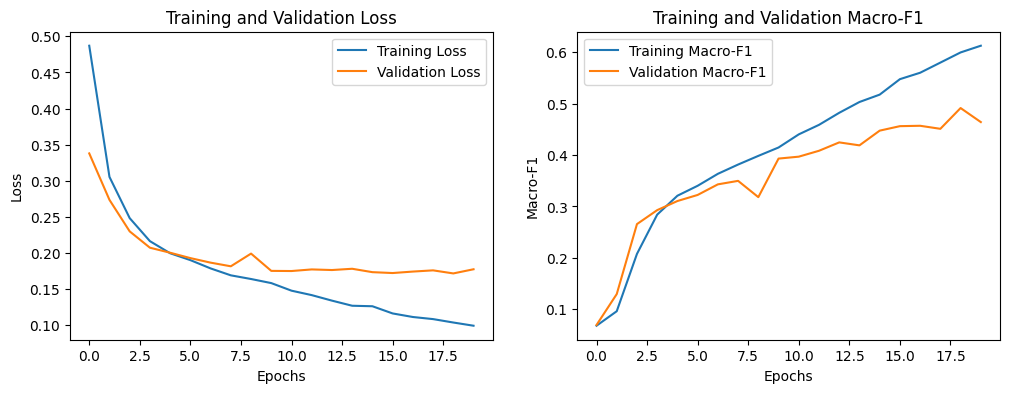

In [5]:
# Generate plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Training Macro-F1')
plt.plot(val_f1s, label='Validation Macro-F1')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1')
plt.legend()
plt.title('Training and Validation Macro-F1')
plt.show()

In [19]:
# Save the model for future inference
torch.save(model.state_dict(), 't1_model4_fasttext.pt')